## Convolutional Neural Networks (CNN)
- Known for their abilities to find patterns in visual data.
- It follows the typical structure of a convolutional neural network:

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer
- Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

In [41]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [42]:
# Setup training data
train_dataset = datasets.FashionMNIST(root='./data',
                                      train=True, # get the train data
                                      download=True,
                                      transform=ToTensor(),
                                      target_transform=None)

# Setup testing data
test_dataset = datasets.FashionMNIST(root='./data',
                                     train=False, # get the test data and not train data
                                     download=True,
                                     transform=ToTensor())

In [43]:
classes= train_dataset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [44]:
# Creation of dataloader

#Set the batch size
batch_size = 32

#Load the training data
train_dataloader = DataLoader(
                              train_dataset, #load the data
                              batch_size=batch_size, # samples per batch
                              shuffle=True # shuffle data every epoch
                              )

#Load the testing data
test_dataloader = DataLoader(
                              test_dataset, #load the data
                              batch_size=batch_size, # samples per batch
                              shuffle=False # shuffle data every epoch is not necessary
                              )
len(train_dataloader),len(test_dataloader) # give u size of each batch

(1875, 313)

In [45]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss_total, train_acc = 0, 0
    model.to(device)
    for batch, (X, Y) in enumerate(data_loader):
        # Send data to GPU
        X, Y = X.to(device), Y.to(device)

        # 1. Forward pass
        train_predcition = model(X)

        # 2. Calculate loss
        train_loss = loss_fn(train_predcition, Y)
        train_loss_total+= train_loss
        train_acc += accuracy_fn(y_true=Y,
                                 y_pred=train_predcition.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        train_loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss_total /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss_total:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss_total, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, Y in data_loader:
            # Send data to GPU
            X, Y = X.to(device), Y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss_total += loss_fn(test_pred, Y)
            test_acc += accuracy_fn(y_true=Y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss_total /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss_total:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [47]:
# CNN model
class Model_CNN(nn.Module):
    def __init__(self,in_channels,out_features,hidden_units):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=hidden_units,
                      kernel_size=3, #how big square should be
                      stride=1, #
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=out_features),
        )

    #Forward Pass
    def forward(self,x:torch.Tensor):
        x = self.block1(x)
        #print(x.shape)
        x = self.block2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

## Hyper Parameters of CNN Architecture
These are the parameters which are set by the us. The in_channel symbolises the input channels that is the dimension eg. [grey_scale:1, height:28, width:28] means in_channels are 3 same as that in Linear. The out_channels are the number of the filters out of which is the classification is to be undertaken same as that of Linear. Hidden units are neurons which are created by the model for better visualization of data again same as that of Linear. In CNN the major change happens in the way the data is visualized. All the data and pixels are visualized in the form of gird. The in_channels tell the neural network to form a grid of that many squares. Padding tells, how many squares to be added outside the in_channel grid. The data visualization happens in the grid format itself. The grid size is decided as per the value of kernels. If kernel is set as 3 then it would form a (3,3) grid. Strid tell the model how many squares to jump while observing and inferring the patterns. This all takes places in nn.Conv2d, where 2d used in this means that the image data is 2 dimensional i.e. only height and width is present.. This data is then passed in it also has the non-linearity factor  set. Every collection  sequential layer on nn.Conv2d is called a block of layers or only block.After every CNN layer Pooling takes place where the maximum useful data is pooled out of the image. Then this data is passed on to linear layer where nn.Flatten is  added.This is a crucial step that converts the 2D feature maps into a single long 1D vector. This vector is then passed to the final nn.Linear layers, where the out_features of the very last linear layer must match the number of classes you are predicting.Essentially, every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

In [48]:
#Instance of model

model = Model_CNN(in_channels=1,
                  hidden_units=10,
                  out_features=len(classes))
model

Model_CNN(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [49]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [50]:
# Loss Function, accuracy function and Optimizer
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

In [67]:
from tqdm import tqdm

torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'---------Epoch: {epoch + 1}--------- \n')
    train_step(model = model,
               data_loader = train_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn)
    test_step(model = model,
              data_loader = test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

---------Epoch: 1--------- 

Train loss: 0.34164 | Train accuracy: 87.65%


 33%|███▎      | 1/3 [00:10<00:21, 10.77s/it]

Test loss: 0.38273 | Test accuracy: 86.41%

---------Epoch: 2--------- 

Train loss: 0.33781 | Train accuracy: 87.62%


 67%|██████▋   | 2/3 [00:21<00:10, 10.73s/it]

Test loss: 0.38472 | Test accuracy: 86.38%

---------Epoch: 3--------- 

Train loss: 0.34223 | Train accuracy: 87.60%


100%|██████████| 3/3 [00:32<00:00, 10.69s/it]

Test loss: 0.38750 | Test accuracy: 86.19%



In [68]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [69]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [70]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[5.9904e-13, 4.7224e-14, 4.4423e-16, 9.6349e-18, 1.4940e-17, 1.0000e+00,
         2.4415e-14, 2.9518e-08, 5.0875e-09, 2.9079e-08],
        [4.6687e-04, 9.9638e-01, 4.4274e-06, 2.6135e-03, 4.8598e-04, 2.4340e-09,
         5.2419e-05, 6.9978e-15, 3.7378e-07, 1.7892e-09]])

In [71]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [72]:
test_labels,pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

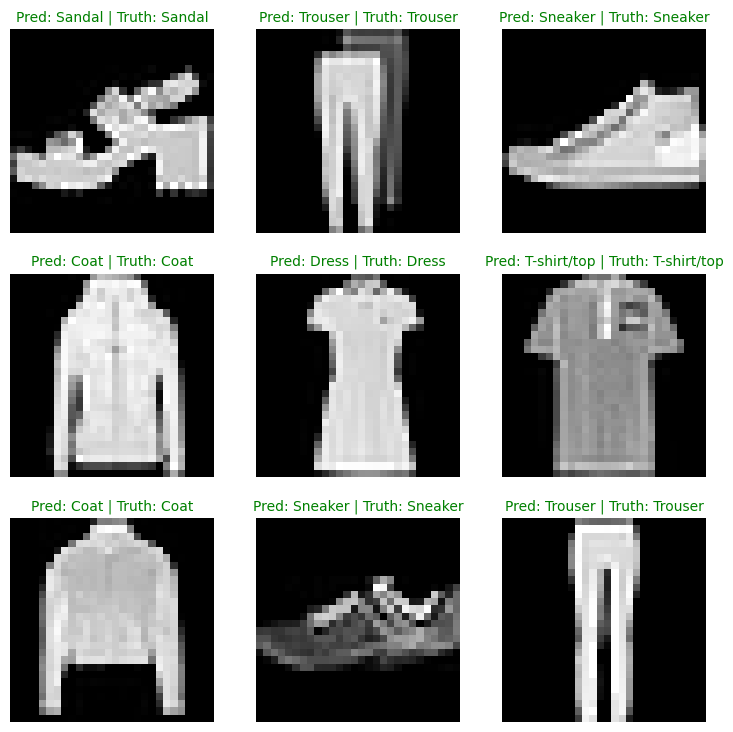

In [73]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);